<a href="https://colab.research.google.com/github/Pushkar0655g/AIML_lab/blob/main/bargain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
# Cell 1: Install & Import (Corrected)
!pip install pettingzoo
!pip install pygame
!pip install gymnasium # Explicitly install gymnasium

import pettingzoo
from pettingzoo.utils.env import AECEnv
from pettingzoo.utils import wrappers
from pettingzoo.utils.agent_selector import agent_selector # <-- THIS IS THE MAIN FIX
from pettingzoo.utils.conversions import to_parallel
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import gymnasium # We will use this for the spaces

print("Libraries installed and imported successfully!")

Libraries installed and imported successfully!


In [55]:
# Cell 2: The Custom "NegotiationEnv" Environment (Corrected)

def env(render_mode=None):
    """
    Creates the negotiation environment.
    """
    internal_render_mode = render_mode if render_mode != "ansi" else "human"
    env = raw_env(render_mode=internal_render_mode)
    # This wrapper makes the environment easier to use
    env = wrappers.AssertOutOfBoundsWrapper(env)
    env = wrappers.OrderEnforcingWrapper(env)
    return env

class raw_env(AECEnv):
    """
    Custom 2-agent "Divide the Pie" environment.

    Agents: proposer_0, responder_0
    Total Items: 10

    Proposer Actions: 0-10 (how many items to *keep* for itself)
    Responder Actions: 0 (Reject), 1 (Accept)
    """
    metadata = {
        "render_modes": ["human"],
        "name": "negotiation-v0",
        "is_parallelizable": False,
        "render_fps": 1,
    }

    def __init__(self, render_mode=None):
        super().__init__()
        self.render_mode = render_mode

        self.agents = ["proposer_0", "responder_0"]
        self.possible_agents = self.agents[:]

        # Use gymnasium.spaces.Discrete directly
        from gymnasium.spaces import Discrete

        # Proposer has 11 actions (offer to keep 0, 1, ..., 10 items)
        self.action_spaces = {
            "proposer_0": Discrete(11),
            "responder_0": Discrete(2) # Responder has 2 actions (0=Reject, 1=Accept)
        }

        # Observation Spaces:
        # Proposer just sees a "0" (it's time to propose).
        # Responder sees the proposal (0-10).
        self.observation_spaces = {
            "proposer_0": Discrete(1),
            "responder_0": Discrete(11)
        }

        # This line now works because agent_selector is the class
        self._agent_selector = agent_selector(self.agents)
        self.reinit()

    def reinit(self):
        self.agents = self.possible_agents[:]
        self._agent_selector.reinit(self.agents)
        self.agent_selection = self._agent_selector.next()

        # Internal state
        self._proposal = -1 # Stores the proposal
        self.rewards = {agent: 0 for agent in self.agents}
        self._cumulative_rewards = {agent: 0 for agent in self.agents}
        self.terminations = {agent: False for agent in self.agents}
        self.truncations = {agent: False for agent in self.agents}
        self.infos = {agent: {} for agent in self.agents}

    def reset(self, seed=None, options=None):
        self.reinit()
        # Return the first observation for the first agent
        obs, _ = self.last() # Get initial observation
        return obs

    # -----------------------------------------------------------------
    # --- THIS IS THE FIXED FUNCTION ---
    # -----------------------------------------------------------------
    def observe(self, agent):
        if agent == "proposer_0":
            # Proposer doesn't need info, it just acts.
            # Return a numpy scalar with the correct dtype
            return np.array(0, dtype=np.int64)
        else:
            # Responder observes the proposal made by the proposer.
            # Return it as a numpy scalar with the correct dtype
            return np.array(self._proposal, dtype=np.int64)
    # -----------------------------------------------------------------
    # -----------------------------------------------------------------

    def step(self, action):
        if self.terminations[self.agent_selection] or self.truncations[self.agent_selection]:
            # This handles if we try to step after the environment is done
            return self._was_dead_step(action)

        agent = self.agent_selection

        # Store the action in info, which is required by the api_test
        self.infos[agent]["action"] = action

        # --- Main Game Logic ---
        if agent == "proposer_0":
            # The proposer makes its offer
            self._proposal = action # action is 0-10
            self.rewards[agent] = 0 # Proposer gets no reward *yet*

        elif agent == "responder_0":
            # The responder accepts (1) or rejects (0)
            if action == 1: # Accept
                # Negotiation success! Distribute rewards.
                self.rewards["proposer_0"] = self._proposal
                self.rewards["responder_0"] = 10 - self._proposal
            else: # Reject
                # Negotiation failure. Both get 0.
                self.rewards["proposer_0"] = 0
                self.rewards["responder_0"] = 0

            # This is the end of the round for both agents
            self.terminations = {agent: True for agent in self.agents}

        # --- End Game Logic ---

        # Update cumulative rewards
        for ag in self.agents:
            self._cumulative_rewards[ag] += self.rewards[ag]

        # Select the next agent in the cycle
        self.agent_selection = self._agent_selector.next()

        if self.render_mode == "human":
            self.render()

        # The api_test requires step() to return the next observation
        # But in AECEnv, we just trigger the next agent
        # The rewards/dones are fetched with last()
        # So we add this line to conform
        self._dones_step_first()


    def render(self):
        if self.render_mode == "human":
            if self.agent_selection == "responder_0":
                print(f"Turn: Proposer, Action: Proposed to keep {self._proposal} items.")
            else:
                if self._proposal != -1: # check if a proposal was made
                    accepted = self.rewards["proposer_0"] > 0 or self.rewards["responder_0"] > 0
                    if not accepted and self.terminations["responder_0"]:
                        print(f"Turn: Responder, Action: REJECTED proposal of {self._proposal}.")
                        print("--- Round Over (REJECT) ---")
                    elif accepted:
                        print(f"Turn: Responder, Action: ACCEPTED proposal of {self._proposal}.")
                        print(f"--- Round Over (ACCEPT) ---")
                        print(f"Rewards: Proposer={self.rewards['proposer_0']}, Responder={self.rewards['responder_0']}")

    # --- Required methods ---
    def state(self):
        # A simple state representation (the proposal)
        return np.array([self._proposal])

    def close(self):
        pass # No resources to clean up

    def observation_space(self, agent):
        return self.observation_spaces[agent]

    def action_space(self, agent):
        return self.action_spaces[agent]

print("Custom Environment 'raw_env' corrected successfully!")

Custom Environment 'raw_env' corrected successfully!


In [56]:
# Cell 3: Test the Environment
from pettingzoo.test import api_test

# Create the environment
my_env = env()

# This is a standard test from PettingZoo to check if your env is valid
# It will run several episodes with random actions
api_test(my_env, num_cycles=10, verbose_progress=False)

print("\n✅ --- API Test Passed! --- ✅")
print("Your custom environment is set up correctly and follows the PettingZoo API.")

Starting API test
Passed API test

✅ --- API Test Passed! --- ✅
Your custom environment is set up correctly and follows the PettingZoo API.


/usr/local/lib/python3.12/dist-packages/pettingzoo/test/api_test.py:175: UserWarning: Observation numpy array is all zeros.
  warnings.warn("Observation numpy array is all zeros.")
/usr/local/lib/python3.12/dist-packages/pettingzoo/test/api_test.py:274: UserWarning: Agents have different observation space sizes
  warnings.warn("Agents have different observation space sizes")


In [61]:
# Cell 4: The IQL Training Loop & Agent Class (Corrected)

# --- Q-Learning Agent Class ---
# (This class is slightly updated to be more robust)
class QLearningAgent:
    def __init__(self, action_space, alpha=0.1, gamma=0.99, epsilon=1.0):
        self.action_space = action_space
        self.q_table = defaultdict(lambda: np.zeros(self.action_space.n))
        self.alpha = alpha     # Learning rate
        self.gamma = gamma     # Discount factor
        self.epsilon = epsilon   # Exploration rate

    def get_action(self, state):
        # Convert state to a hashable tuple key
        # np.array([state]).flatten() handles both scalar and array states
        state_key = tuple(np.array([state]).flatten())

        # Epsilon-greedy action selection
        if random.random() < self.epsilon:
            return self.action_space.sample() # Explore
        else:
            # Exploit: return the best action from Q-table
            return np.argmax(self.q_table[state_key])

    def update_q_table(self, state, action, reward, next_state, done):
        # Convert states to hashable tuple keys
        state_key = tuple(np.array([state]).flatten())

        # Get Q-value for the current state-action pair
        old_q_value = self.q_table[state_key][action]

        # Get the max Q-value for the next state
        if done:
            next_max_q = 0 # No future reward if the episode is done
        else:
            next_state_key = tuple(np.array([next_state]).flatten())
            next_max_q = np.max(self.q_table[next_state_key])

        # The Q-Learning update rule
        # Q(s,a) = Q(s,a) + alpha * (reward + gamma * max_q_next - Q(s,a))
        new_q_value = old_q_value + self.alpha * (reward + self.gamma * next_max_q - old_q_value)

        self.q_table[state_key][action] = new_q_value

# --- Hyperparameters ---
num_episodes = 50_000
epsilon_start = 1.0
min_epsilon = 0.01
# We'll decay epsilon over 80% of the episodes
epsilon_decay = (epsilon_start - min_epsilon) / (num_episodes * 0.8)

# --- Initialize Environment and Agents ---
train_env = env()
agents = {
    "proposer_0": QLearningAgent(train_env.action_space("proposer_0"), alpha=0.1, gamma=0.99, epsilon=epsilon_start),
    "responder_0": QLearningAgent(train_env.action_space("responder_0"), alpha=0.1, gamma=0.99, epsilon=epsilon_start)
}

# --- Training Log ---
total_reward_history = []
print("Agents initialized. Starting training...")

# --- Main Training Loop ---
for episode in range(num_episodes):

    # --- Reset environment and get initial state ---
    train_env.reset()

    # Store experiences for the two-step turn
    proposer_obs = None
    proposer_action = None
    responder_obs = None
    responder_action = None

    current_episode_rewards = defaultdict(int)

    # --- Run one full episode (one negotiation) ---
    for agent_name in train_env.agent_iter():

        observation, reward, termination, truncation, info = train_env.last()
        done = termination or truncation

        # Sum up rewards as we go
        current_episode_rewards[agent_name] += reward

        if done:
            # If agent is done, we must pass None to step() to
            # satisfy the OrderEnforcingWrapper
            train_env.step(None)
            continue # Go to the next agent

        # --- If agent is NOT done, select an action ---
        action = agents[agent_name].get_action(observation)

        # Store the observation and action for the update later
        if agent_name == "proposer_0":
            proposer_obs = observation
            proposer_action = action
        else: # responder_0
            responder_obs = observation
            responder_action = action

        # Take the action in the environment
        train_env.step(action)

    # --- End of Episode (agent_iter loop is finished) ---

    # Now that the episode is over, we have all the pieces to learn
    # Proposer's reward
    proposer_reward = current_episode_rewards["proposer_0"]
    # Responder's reward
    responder_reward = current_episode_rewards["responder_0"]

    # Update Proposer: its "next state" was the responder's observation
    agents["proposer_0"].update_q_table(proposer_obs, proposer_action, proposer_reward, responder_obs, True)

    # Update Responder: its "next state" is terminal (None)
    agents["responder_0"].update_q_table(responder_obs, responder_action, responder_reward, None, True)

    # Decay epsilon for both agents
    new_epsilon = max(min_epsilon, agents["proposer_0"].epsilon - epsilon_decay)
    agents["proposer_0"].epsilon = new_epsilon
    agents["responder_0"].epsilon = new_epsilon

    # Log total rewards
    total_reward = proposer_reward + responder_reward
    total_reward_history.append(total_reward)

    if (episode + 1) % 5000 == 0:
        print(f"Episode {episode + 1}/{num_episodes} | Avg. Total Reward: {np.mean(total_reward_history[-1000:]):.2f} | Epsilon: {new_epsilon:.3f}")

print("\n✅ --- Training finished! --- ✅")

Agents initialized. Starting training...
Episode 5000/50000 | Avg. Total Reward: 5.50 | Epsilon: 0.876
Episode 10000/50000 | Avg. Total Reward: 5.91 | Epsilon: 0.752
Episode 15000/50000 | Avg. Total Reward: 6.67 | Epsilon: 0.629
Episode 20000/50000 | Avg. Total Reward: 7.13 | Epsilon: 0.505
Episode 25000/50000 | Avg. Total Reward: 7.98 | Epsilon: 0.381
Episode 30000/50000 | Avg. Total Reward: 8.75 | Epsilon: 0.257
Episode 35000/50000 | Avg. Total Reward: 9.17 | Epsilon: 0.134
Episode 40000/50000 | Avg. Total Reward: 9.86 | Epsilon: 0.010
Episode 45000/50000 | Avg. Total Reward: 9.89 | Epsilon: 0.010
Episode 50000/50000 | Avg. Total Reward: 10.00 | Epsilon: 0.010

✅ --- Training finished! --- ✅


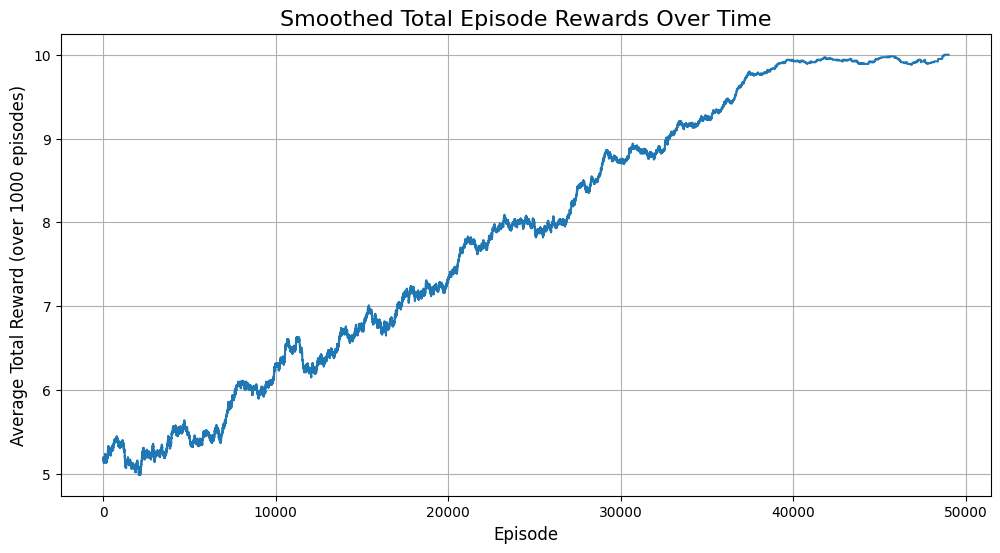


     INSPECTING AGENT BRAINS (Q-TABLES)

--- Proposer's Learned Q-Values ---
Q-values for state (np.int64(0),) ('Time to propose'):
Action (keep) | Q-Value
-----------------------
      0       | +0.00
      1       | +0.90
      2       | +1.97
      3       | +2.84
      4       | +3.95
      5       | +4.89
      6       | +6.00
      7       | +6.95
      8       | +7.53
      9       | +9.00
     10       | +0.06

>> Proposer's Best Action: Keep 9 items (offering 1)


--- Responder's Learned Q-Values ---
(Action 0 = REJECT, Action 1 = ACCEPT)

State (proposal) | Q-Value for REJECT | Q-Value for ACCEPT | Decision
--------------------------------------------------------------------------
 Proposer keeps  0 |      +0.00         |      +10.00         | **ACCEPT**
 Proposer keeps  1 |      +0.00         |      +9.00         | **ACCEPT**
 Proposer keeps  2 |      +0.00         |      +8.00         | **ACCEPT**
 Proposer keeps  3 |      +0.00         |      +7.00         | **ACCEPT**
 P

In [62]:
# Cell 5: Plot the Training Results & Inspect Q-Tables

# --- 1. Plot the Learning Curve ---

def smooth_rewards(rewards, window_size=1000):
    """Simple moving average to smooth the reward curve"""
    smoothed = []
    for i in range(len(rewards) - window_size):
        smoothed.append(np.mean(rewards[i:i+window_size]))
    return smoothed

plt.figure(figsize=(12, 6))
plt.plot(smooth_rewards(total_reward_history))
plt.title("Smoothed Total Episode Rewards Over Time", fontsize=16)
plt.xlabel("Episode", fontsize=12)
plt.ylabel("Average Total Reward (over 1000 episodes)", fontsize=12)
plt.grid(True)
plt.show()


# --- 2. Inspect the Learned Q-Tables (The "Brains") ---

print("\n" + "="*50)
print("     INSPECTING AGENT BRAINS (Q-TABLES)")
print("="*50 + "\n")

# --- Proposer's Brain ---
print("--- Proposer's Learned Q-Values ---")
# The proposer's state is always 0. We convert it to a tuple key.
proposer_state_key = tuple(np.array([0]).flatten())
proposer_q_values = agents["proposer_0"].q_table[proposer_state_key]

print(f"Q-values for state {proposer_state_key} ('Time to propose'):")
print("Action (keep) | Q-Value")
print("-----------------------")
for action, q_value in enumerate(proposer_q_values):
    print(f"     {action:2d}       | {q_value:+.2f}")

best_proposer_action = np.argmax(proposer_q_values)
print(f"\n>> Proposer's Best Action: Keep {best_proposer_action} items (offering {10 - best_proposer_action})\n")


# --- Responder's Brain ---
print("\n--- Responder's Learned Q-Values ---")
print("(Action 0 = REJECT, Action 1 = ACCEPT)\n")
print("State (proposal) | Q-Value for REJECT | Q-Value for ACCEPT | Decision")
print("--------------------------------------------------------------------------")

for state in range(11): # For each possible proposal (0-10)
    # Convert state to the tuple key
    state_key = tuple(np.array([state]).flatten())
    q_values = agents["responder_0"].q_table[state_key]

    # If the agent hasn't seen this state, Q-values will be 0
    if np.all(q_values == 0):
        decision = "Untrained (N/A)"
    else:
        decision = "ACCEPT" if np.argmax(q_values) == 1 else "REJECT"

    print(f" Proposer keeps {state:2d} |      {q_values[0]:+.2f}         |      {q_values[1]:+.2f}         | **{decision}**")

In [70]:
# Cell 6: Final Showcase Demo Function (Corrected)

def run_showcase_demo(proposer, responder):
    """
    Runs a single, visible negotiation round with trained agents.
    """
    print("🤖 --- Starting 'Bargain Bots' Showcase --- 🤖\n")

    # Create a new environment with human-readable rendering
    demo_env = env(render_mode="human")
    demo_env.reset()

    # Turn off exploration for the demo (we want to see what they *learned*)
    proposer.epsilon = 0.0
    responder.epsilon = 0.0

    # --- THIS IS THE FIX (Part 1) ---
    # We create a local dict to store rewards as they happen
    final_rewards = defaultdict(int)

    for agent_name in demo_env.agent_iter():
        observation, reward, termination, truncation, info = demo_env.last()

        # --- THIS IS THE FIX (Part 2) ---
        # We add the reward to our local dict *every* turn
        final_rewards[agent_name] += reward

        if termination or truncation:
            demo_env.step(None)
            continue

        # Get the correct agent
        agent = proposer if agent_name == "proposer_0" else responder

        # --- AGENT MAKES A DECISION ---
        action = agent.get_action(observation)

        # Store for analysis
        if agent_name == "proposer_0":
            prop_action = action
            print(f"Agent [Proposer]: 'My goal is to maximize my reward.'")
            print(f"Agent [Proposer]: (Thinking... best Q-value is for action {action})")
        else:
            resp_action = action

            # Convert scalar state to tuple key
            resp_state_key = tuple(np.array([observation]).flatten())
            print(f"Agent [Responder]: 'I see the offer. I get {10 - observation} items.'")
            print(f"Agent [Responder]: (Thinking... Q for ACCEPT is {responder.q_table[resp_state_key][1]:.2f}, Q for REJECT is {responder.q_table[resp_state_key][0]:.2f})")

        demo_env.step(action)

    print("\n--- Negotiation Concluded ---")

    # --- THIS IS THE FIX (Part 3) ---
    # We read from our local `final_rewards` dict, not the stale demo_env.rewards
    prop_reward = final_rewards["proposer_0"]
    resp_reward = final_rewards["responder_0"]

    print(f"\n🏆 Final Result:")
    print(f"   Proposer kept: {prop_reward} items")
    print(f"   Responder got: {resp_reward} items")
    print(f"   Total items exchanged: {prop_reward + resp_reward}")

    if prop_reward == 5:
        print("\nOutcome: A 'fair' 5-5 split!")
    elif prop_reward > 5:
        print(f"\nOutcome: A 'rational but selfish' {prop_reward}-{resp_reward} split. A clear win for the Proposer!")
    else:
        print(f"\nOutcome: An 'generous' {prop_reward}-{resp_reward} split.")

# --- Run the Demo! ---
# We pass in the 'agents' dict you trained in Cell 4
run_showcase_demo(agents["proposer_0"], agents["responder_0"])

🤖 --- Starting 'Bargain Bots' Showcase --- 🤖

Agent [Proposer]: 'My goal is to maximize my reward.'
Agent [Proposer]: (Thinking... best Q-value is for action 9)
Agent [Proposer]: 'My goal is to maximize my reward.'
Agent [Proposer]: (Thinking... best Q-value is for action 9)
Turn: Proposer, Action: Proposed to keep 9 items.
Agent [Responder]: 'I see the offer. I get 1 items.'
Agent [Responder]: (Thinking... Q for ACCEPT is 1.00, Q for REJECT is 0.00)
Turn: Responder, Action: ACCEPTED proposal of 9.
--- Round Over (ACCEPT) ---
Rewards: Proposer=9, Responder=1

--- Negotiation Concluded ---

🏆 Final Result:
   Proposer kept: 9 items
   Responder got: 1 items
   Total items exchanged: 10

Outcome: A 'rational but selfish' 9-1 split. A clear win for the Proposer!
